# Goal:

* Fit the training-data to a few classifiers.
* Measure/visualize the performance using confusion matric and ROC-curve.
* Choose the best model (possibly an ensamble) based on accuracy on the validation-data.
* Save it to file.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
import seaborn as sns

from pickle import dump, load

---
Copy-paste the data loading and the train-val-test split from the *preprocess_visualize.ipynb* notebook.

In [2]:
data_trainval = pd.read_csv(os.path.join('data', 'train.csv'))
X_trainval = data_trainval[data_trainval.columns.drop('Survived')]
y_trainval = data_trainval.Survived

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify = y_trainval, random_state=42)

In [3]:
X_val.shape

(90, 11)

In [4]:
y_val.value_counts() / len(y_val)

0    0.611111
1    0.388889
Name: Survived, dtype: float64

---
Define plotting utilities

In [5]:
def confusion_matrix_on_val(name, estimator):
    y_val_pred = estimator.predict(X_val)

    print(f"{name}:")
    print(f"Accuracy on validation: {accuracy_score(y_val, y_val_pred)}")

    cm = confusion_matrix(y_val, y_val_pred)
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 5)
    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('True', fontsize=14)
    plt.title(f'Confusion matrix on validation', fontsize=15)
    plt.show()
    
def ROC_on_val(estimators):
    
    fig, ax = plt.subplots(ncols=1)
    fig.set_size_inches(6, 6)
    
    for name, estimator in estimators.items():
        
        y_val_proba = estimator.predict_proba(X_val)[:,1]    
        fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
        ax.plot(fpr, tpr, label=name)

    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)
    ax.legend()
    plt.show()

---
Build the preprocessing pipeline by running the script. It contains only class definitions and class instantiations (and occasional definition of a constant). 

In [6]:
%run build_preprocess_pipe.py

We can do e.g.

In [7]:
preprocess = preprocessing_pipe().fit(X_train)

---
As a warmup, fit a few classifiers without tuning anything. We need models that can give a probability estimate. This rules out SVM-based classifiers.

In [8]:
X_train_preprocess = preprocess.transform(X_train)
X_val_preprocess = preprocess.transform(X_val)

In [9]:
neighbors = KNeighborsClassifier(n_neighbors=5).fit(X_train_preprocess, y_train)
neighbors.score(X_val_preprocess, y_val)

0.6777777777777778

In [10]:
log_reg = LogisticRegression(random_state=123, solver = 'lbfgs').fit(X_train_preprocess, y_train)
print(log_reg.score(X_train_preprocess, y_train))
print(log_reg.score(X_val_preprocess, y_val))

0.83270911360799
0.8555555555555555


In [11]:
bayes_gauss = GaussianNB().fit(X_train_preprocess, y_train)
print(bayes_gauss.score(X_train_preprocess, y_train))
print(bayes_gauss.score(X_val_preprocess, y_val))

0.7415730337078652
0.6777777777777778


In [12]:
bayes_complement = ComplementNB().fit(X_train_preprocess, y_train)
print(bayes_complement.score(X_train_preprocess, y_train))
print(bayes_complement.score(X_val_preprocess, y_val))

0.7403245942571786
0.7111111111111111


In [13]:
rand_forest = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=123).fit(X_train_preprocess, y_train)
print(rand_forest.score(X_train_preprocess, y_train))
print(rand_forest.score(X_val_preprocess, y_val))

0.8789013732833958
0.8


In [14]:
grad_boost = GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=123, learning_rate=0.1, subsample=0.9).fit(X_train_preprocess, y_train)
print(grad_boost.score(X_train_preprocess, y_train))
print(grad_boost.score(X_val_preprocess, y_val))

0.9225967540574282
0.8222222222222222


In [15]:
ada_boost = AdaBoostClassifier(base_estimator=ComplementNB(), n_estimators=150, learning_rate=0.5, random_state=123).fit(X_train_preprocess, y_train)
print(ada_boost.score(X_train_preprocess, y_train))
print(ada_boost.score(X_val_preprocess, y_val))

0.8314606741573034
0.8222222222222222


Unsurprisingly, bare KNeighborsClassifier does not keep up. The naive Bayes's also struggle, unless Ada-boosted. GradientBoosted trees are easy to overfit, wheras Logistic Regression seems rather robust in that regard. Let's choose Logistic Regression, GradientBoosted trees and AdaBoosted Complement NaiveBayes for futher tuning.

---

## GridSearch: Logistic Regression

In [16]:
logreg_clf = Pipeline([
    ('preprocess', preprocessing_pipe()),
    ('clf', LogisticRegression(solver='saga', max_iter=1e5))
])

In [17]:
param_grid = {}
param_grid['preprocess__numerical_transformer__fare_transformer__scaler__feature_range'] = [(0.1, 0.9),  (0.3, 0.7)]
param_grid['preprocess__numerical_transformer__age_discretizer__tresholds'] = [[5,10,20,60], [2,5,10,20,30,40,50,60]]
param_grid['clf__C'] = [0.5, 1, 5, 10]
param_grid['clf__penalty'] = ['l1', 'l2']

logreg_clf_cv = GridSearchCV(logreg_clf, param_grid, cv=4, refit=True, return_train_score=True, n_jobs=-1).fit(X_train, y_train)

In [18]:
with open("logreg_clf_cv.pkl", "wb") as file:
    dump(logreg_clf_cv, file)

In [19]:
with open("logreg_clf_cv.pkl", "rb") as file:
    logreg_clf_cv = load(file)

Results of the Grid Search are given in the table below. One may choose which columns to display by specifying the corresponding number from the dictionary below.

In [20]:
column_translate = {key: idx for (idx, key) in enumerate(logreg_clf_cv.cv_results_.keys())}
{idx: key for (idx, key) in enumerate(logreg_clf_cv.cv_results_.keys())}

{0: 'mean_fit_time',
 1: 'std_fit_time',
 2: 'mean_score_time',
 3: 'std_score_time',
 4: 'param_clf__C',
 5: 'param_clf__penalty',
 6: 'param_preprocess__numerical_transformer__age_discretizer__tresholds',
 7: 'param_preprocess__numerical_transformer__fare_transformer__scaler__feature_range',
 8: 'params',
 9: 'split0_test_score',
 10: 'split1_test_score',
 11: 'split2_test_score',
 12: 'split3_test_score',
 13: 'mean_test_score',
 14: 'std_test_score',
 15: 'rank_test_score',
 16: 'split0_train_score',
 17: 'split1_train_score',
 18: 'split2_train_score',
 19: 'split3_train_score',
 20: 'mean_train_score',
 21: 'std_train_score'}

In [21]:
choose = [4, 5, 6, 7, 13, 20, 0]
sort_by = 13
results = pd.DataFrame(logreg_clf_cv.cv_results_).iloc[:, choose].rename(columns=column_translate).sort_values(sort_by, ascending=False)
results.iloc[:6]

,4,5,6,7,13,20,0
14,1,l2,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.816479,0.837690,0.209603
23,5,l2,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.3, 0.7)",0.816479,0.838111,0.222070
10,1,l1,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.816479,0.833947,0.211334
4,0.5,l2,"[5, 10, 20, 60]","(0.1, 0.9)",0.815231,0.827708,0.170606
5,0.5,l2,"[5, 10, 20, 60]","(0.3, 0.7)",0.815231,0.828540,0.147993
6,0.5,l2,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.815231,0.831446,0.153850


Logistic Regression:
Accuracy on validation: 0.8222222222222222


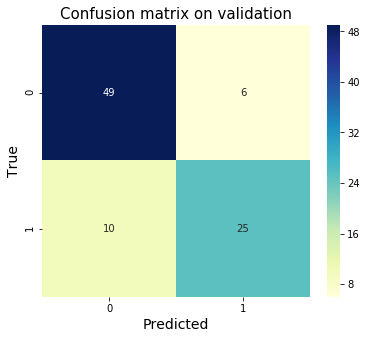

In [22]:
confusion_matrix_on_val("Logistic Regression", logreg_clf_cv.best_estimator_)

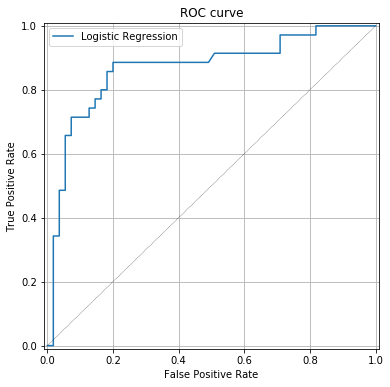

In [23]:
ROC_on_val({"Logistic Regression": logreg_clf_cv.best_estimator_})

---
## GridSearch: GradienBoosting

In [24]:
gradboost_clf = Pipeline([
    ('preprocess', preprocessing_pipe()),
    ('clf', GradientBoostingClassifier(random_state=123))
])

param_grid = {}
param_grid['preprocess__numerical_transformer__fare_transformer__scaler__feature_range'] = [(0.1, 0.9),  (0.3, 0.7)]
param_grid['preprocess__numerical_transformer__age_discretizer__tresholds'] = [[5,10,20,60], [2,5,10,20,30,40,50,60]]
param_grid['clf__n_estimators'] = [80, 100, 150]
param_grid['clf__max_depth'] = [2, 3, 5]
param_grid['clf__learning_rate'] = [0.05, 0.1, 0.5]
param_grid['clf__subsample'] = [0.1, 0.5, 1]

gradboost_clf_cv = GridSearchCV(gradboost_clf, param_grid, cv=4, refit=True, return_train_score=True, n_jobs=-1, iid=False,).fit(X_train, y_train)

In [25]:
with open("gradboost_clf_cv.pkl", "wb") as file:
    dump(gradboost_clf_cv, file)

In [26]:
with open("gradboost_clf_cv.pkl", "rb") as file:
    gradboost_clf_cv = load(file)

In [27]:
column_translate = {key: idx for (idx, key) in enumerate(gradboost_clf_cv.cv_results_.keys())}
{idx: key for (idx, key) in enumerate(gradboost_clf_cv.cv_results_.keys())}

{0: 'mean_fit_time',
 1: 'std_fit_time',
 2: 'mean_score_time',
 3: 'std_score_time',
 4: 'param_clf__learning_rate',
 5: 'param_clf__max_depth',
 6: 'param_clf__n_estimators',
 7: 'param_clf__subsample',
 8: 'param_preprocess__numerical_transformer__age_discretizer__tresholds',
 9: 'param_preprocess__numerical_transformer__fare_transformer__scaler__feature_range',
 10: 'params',
 11: 'split0_test_score',
 12: 'split1_test_score',
 13: 'split2_test_score',
 14: 'split3_test_score',
 15: 'mean_test_score',
 16: 'std_test_score',
 17: 'rank_test_score',
 18: 'split0_train_score',
 19: 'split1_train_score',
 20: 'split2_train_score',
 21: 'split3_train_score',
 22: 'mean_train_score',
 23: 'std_train_score'}

In [28]:
choose = [4, 5, 6, 7, 8, 9, 15, 20, 0]
sort_by = 15
results = pd.DataFrame(gradboost_clf_cv.cv_results_).iloc[:, choose].rename(columns=column_translate).sort_values(sort_by, ascending=False)
results.iloc[:6]

,4,5,6,7,8,9,15,20,0
127,0.1,2,100,0.5,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.3, 0.7)",0.831397,0.865225,0.286646
126,0.1,2,100,0.5,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.831397,0.865225,0.290636
143,0.1,2,150,1,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.3, 0.7)",0.827659,0.893511,0.308671
142,0.1,2,150,1,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.827659,0.893511,0.303605
162,0.1,3,100,0.5,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.827640,0.906822,0.339001
163,0.1,3,100,0.5,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.3, 0.7)",0.827640,0.906822,0.361536


Gradient Boosting:
Accuracy on validation: 0.8


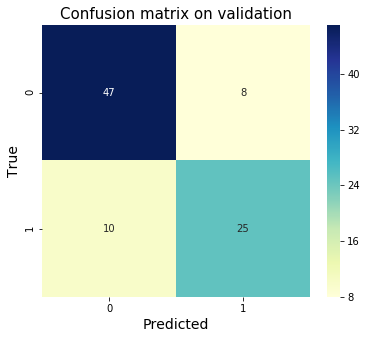

In [29]:
confusion_matrix_on_val("Gradient Boosting", gradboost_clf_cv.best_estimator_)

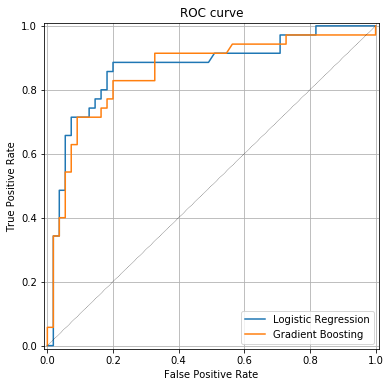

In [30]:
ROC_on_val({"Logistic Regression": logreg_clf_cv.best_estimator_,
            "Gradient Boosting": gradboost_clf_cv.best_estimator_
           })

---
## GridSearch: AdaBoost + NaiveBayes

In [31]:
adaboost_clf = Pipeline([
    ('preprocess', preprocessing_pipe()),
    ('clf', AdaBoostClassifier(base_estimator=ComplementNB(), n_estimators=150, learning_rate=0.5, random_state=123).fit(X_train_preprocess, y_train))
])

param_grid = {}
param_grid['preprocess__numerical_transformer__fare_transformer__scaler__feature_range'] = [(0.1, 0.9),  (0.3, 0.7)]
param_grid['preprocess__numerical_transformer__age_discretizer__tresholds'] = [[5,10,20,60], [2,5,10,20,30,40,50,60]]
param_grid['clf__n_estimators'] = [80, 100, 150]
param_grid['clf__learning_rate'] = [0.05, 0.1, 0.5]
param_grid['clf__base_estimator__alpha'] = [0, 0.1, 0.5]

adaboost_clf_cv = GridSearchCV(adaboost_clf, param_grid, cv=4, refit=True, return_train_score=True, n_jobs=-1, iid=False,).fit(X_train, y_train)

In [32]:
with open("adaboost_clf_cv.pkl", "wb") as file:
    dump(adaboost_clf_cv, file)

In [33]:
with open("adaboost_clf_cv.pkl", "rb") as file:
    adaboost_clf_cv = load(file)

In [34]:
column_translate = {key: idx for (idx, key) in enumerate(adaboost_clf_cv.cv_results_.keys())}
{idx: key for (idx, key) in enumerate(adaboost_clf_cv.cv_results_.keys())}

{0: 'mean_fit_time',
 1: 'std_fit_time',
 2: 'mean_score_time',
 3: 'std_score_time',
 4: 'param_clf__base_estimator__alpha',
 5: 'param_clf__learning_rate',
 6: 'param_clf__n_estimators',
 7: 'param_preprocess__numerical_transformer__age_discretizer__tresholds',
 8: 'param_preprocess__numerical_transformer__fare_transformer__scaler__feature_range',
 9: 'params',
 10: 'split0_test_score',
 11: 'split1_test_score',
 12: 'split2_test_score',
 13: 'split3_test_score',
 14: 'mean_test_score',
 15: 'std_test_score',
 16: 'rank_test_score',
 17: 'split0_train_score',
 18: 'split1_train_score',
 19: 'split2_train_score',
 20: 'split3_train_score',
 21: 'mean_train_score',
 22: 'std_train_score'}

In [35]:
choose = [4, 5, 6, 7, 8, 14, 21, 0]
sort_by = 14
results = pd.DataFrame(adaboost_clf_cv.cv_results_).iloc[:, choose].rename(columns=column_translate).sort_values(sort_by, ascending=False)
results.iloc[:6]

,4,5,6,7,8,14,21,0
53,0.1,0.1,100,"[5, 10, 20, 60]","(0.3, 0.7)",0.820172,0.824796,0.556611
63,0.1,0.5,80,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.3, 0.7)",0.820109,0.828953,0.354441
52,0.1,0.1,100,"[5, 10, 20, 60]","(0.1, 0.9)",0.818928,0.823547,0.472895
48,0.1,0.1,80,"[5, 10, 20, 60]","(0.1, 0.9)",0.818916,0.823963,0.422318
106,0.5,0.5,150,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.818878,0.831867,0.594141
62,0.1,0.5,80,"[2, 5, 10, 20, 30, 40, 50, 60]","(0.1, 0.9)",0.818853,0.829370,0.352908


Ada Boosting:
Accuracy on validation: 0.8333333333333334


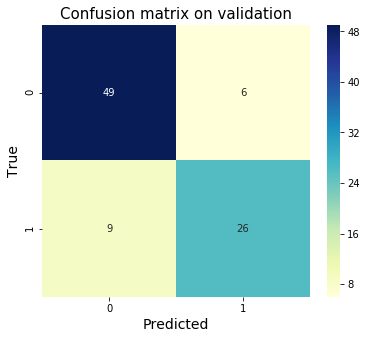

In [36]:
confusion_matrix_on_val("Ada Boosting", adaboost_clf_cv.best_estimator_)

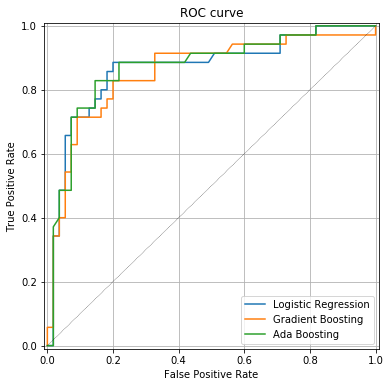

In [37]:
ROC_on_val({"Logistic Regression": logreg_clf_cv.best_estimator_,
            "Gradient Boosting": gradboost_clf_cv.best_estimator_,
            "Ada Boosting": adaboost_clf_cv.best_estimator_
           })

---
## Soft voting of the last three tuned classifiers

In [38]:
vote_clf = VotingClassifier([
                ("Logistic Regression", logreg_clf_cv.best_estimator_),
                ("Gradient Boosting", gradboost_clf_cv.best_estimator_),
                ("Ada Boosting", adaboost_clf_cv.best_estimator_)
            ],
            voting="soft",
            weights = [2,1,10]
            )

In [39]:
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression', Pipeline(memory=None,
     steps=[('preprocess', FeatureUnion(n_jobs=None,
       transformer_list=[('numerical_transformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0,
         transformer_weights=None,
         transformers=[('age_discr..., fit_prior=True, norm=False),
          learning_rate=0.1, n_estimators=100, random_state=123))]))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 1, 10])

Soft Voting:
Accuracy on validation: 0.8333333333333334


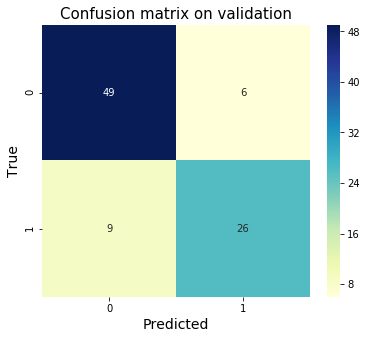

In [40]:
confusion_matrix_on_val("Soft Voting", vote_clf)

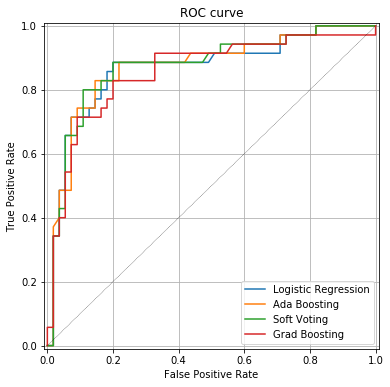

In [41]:
ROC_on_val({"Logistic Regression": logreg_clf_cv.best_estimator_,
            "Ada Boosting": adaboost_clf_cv.best_estimator_,
            "Soft Voting": vote_clf,
            "Grad Boosting": gradboost_clf_cv.best_estimator_
           })

Save the Voting Classifier to a file.

In [42]:
with open("vote_clf.pkl", "wb") as file:
    dump(vote_clf, file)

---
Example of some predicted probabilities...

In [45]:
print(vote_clf.predict_proba(X_val)[:5])

y_val[:5]

[[0.33132895 0.66867105]
 [0.64510121 0.35489879]
 [0.63152162 0.36847838]
 [0.4732634  0.5267366 ]
 [0.60835072 0.39164928]]


530    1
401    0
433    0
241    1
773    0
Name: Survived, dtype: int64

---
# Summary

* The Voting Classifier composed of three classifiers that were tuned with cross-validated grid search and glued together via *soft-voting* (i.e. using weighted some of the predicted probabilities) is our best scoring model so far.

* It is able to assign probability of survival to any record (i.e. passanger).

* We will test it in the next notebook.

---
### End